In [1]:
# Credits: https://github.com/SullyChen/Autopilot-TensorFlow
# Research paper: End to End Learning for Self-Driving Cars by Nvidia. [https://arxiv.org/pdf/1604.07316.pdf]

# NVidia dataset: 72 hrs of video => 72*60*60*30 = 7,776,000 images
# Nvidia blog: https://devblogs.nvidia.com/deep-learning-self-driving-cars/


# Our Dataset: https://github.com/SullyChen/Autopilot-TensorFlow [https://drive.google.com/file/d/0B-KJCaaF7elleG1RbzVPZWV4Tlk/view]
# Size: 25 minutes = 25*60*30 = 45,000 images ~ 2.3 GB


# If you want to try on a slightly large dataset: 70 minutes of data ~ 223GB
# Refer: https://medium.com/udacity/open-sourcing-223gb-of-mountain-view-driving-data-f6b5593fbfa5
# Format: Image, latitude, longitude, gear, brake, throttle, steering angles and speed



# Additional Installations:
# pip3 install h5py


# AWS: https://aws.amazon.com/blogs/machine-learning/get-started-with-deep-learning-using-the-aws-deep-learning-ami/

# Youtube:https://www.youtube.com/watch?v=qhUvQiKec2U
# Further reading and extensions: https://medium.com/udacity/teaching-a-machine-to-steer-a-car-d73217f2492c
# More data: https://medium.com/udacity/open-sourcing-223gb-of-mountain-view-driving-data-f6b5593fbfa5

In [16]:
import warnings
warnings.filterwarnings("ignore")

In [35]:
# read images and steering angles from driving_dataset folder

from __future__ import division

import os
import numpy as np
import random

from scipy import pi
from itertools import islice



DATA_FOLDER = 'C:\\Users\\yacca\\Downloads\\Autopilot-TensorFlow-master\\driving_dataset' # change this to your folder
TRAIN_FILE = os.path.join(DATA_FOLDER, 'data.txt')


split =0.7
X = []
y = []
with open(TRAIN_FILE) as fp:
    for line in fp:
        path, angle = line.strip().split()
        full_path = os.path.join(DATA_FOLDER, path)
        X.append(full_path)
        
        # converting angle from degrees to radians
        y.append(float(angle) * pi / 180 )


y = np.array(y)
print("Completed processing data.txt")

split_index = int(len(y)*split)

train_y = y[:split_index]
test_y = y[split_index:]

          

Completed processing data.txt


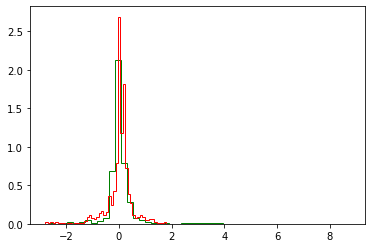

In [36]:
import numpy;
%matplotlib inline
# PDF of train and test 'y' values. 
import matplotlib.pyplot as plt 
plt.hist(train_y, bins=50, normed=1, color='green', histtype ='step');
plt.hist(test_y, bins=50, normed=1, color='red', histtype ='step');
plt.show()




In [37]:
#Model 0: Base line Model: y_test_pred = mean(y_train_i) 
train_mean_y = np.mean(train_y)

print('Test_MSE(MEAN):%f' % np.mean(np.square(test_y-train_mean_y)) )

print('Test_MSE(ZERO):%f' % np.mean(np.square(test_y-0.0)) )


Test_MSE(MEAN):0.241561
Test_MSE(ZERO):0.241107


In [38]:
import scipy

In [39]:
import scipy.misc
import random

xs = []
ys = []

#points to the end of the last batch
train_batch_pointer = 0
val_batch_pointer = 0

#read data.txt
with open("C:\\Users\\yacca\\Downloads\\Autopilot-TensorFlow-master\\driving_dataset\\data.txt") as f:
    for line in f:
        xs.append("C:\\Users\\yacca\\Downloads\\Autopilot-TensorFlow-master\\driving_dataset\\" + line.split()[0])
        #the paper by Nvidia uses the inverse of the turning radius,
        #but steering wheel angle is proportional to the inverse of turning radius
        #so the steering wheel angle in radians is used as the output
        ys.append(float(line.split()[1]) * scipy.pi / 180)

#get number of images
num_images = len(xs)


train_xs = xs[:int(len(xs) * 0.7)]
train_ys = ys[:int(len(xs) * 0.7)]

val_xs = xs[-int(len(xs) * 0.3):]
val_ys = ys[-int(len(xs) * 0.3):]

num_train_images = len(train_xs)
num_val_images = len(val_xs)

num_train_angles=len(train_ys)
num_val_angles=len(val_ys)


In [40]:
print(num_images)

45406


In [41]:
print(num_train_images)
print(num_val_images)
print(num_train_angles)
print(num_val_angles)

31784
13621
31784
13621


## https://www.tensorflow.org/api_docs/python/tf/math/multiply

In [42]:
import tensorflow as tf
print(tf.__version__)  # for Python 3


1.14.0


In [43]:
import scipy
print(scipy.__version__)

1.1.0


### https://i.imgur.com/fAA9qhX.png

In [44]:
train_batch_pointer = 0
val_batch_pointer = 0

# Utility Functions
def LoadTrainBatch(batch_size):
    global train_batch_pointer
    x_out = []
    y_out = []
    for i in range(0, batch_size):
        x_out.append(scipy.misc.imresize(scipy.misc.imread(train_xs[(train_batch_pointer + i) % num_train_images])[-150:], 
                                         [66, 200]) / 255.0)
        y_out.append([train_ys[(train_batch_pointer + i) % num_train_images]])
    train_batch_pointer += batch_size
    return x_out, y_out

def LoadValBatch(batch_size): 
    global val_batch_pointer
    x_out = []
    y_out = []
    for i in range(0, batch_size):
        x_out.append(scipy.misc.imresize(scipy.misc.imread(val_xs[(val_batch_pointer + i) % num_val_images])[-150:], 
                                         [66, 200]) / 255.0)
        y_out.append([val_ys[(val_batch_pointer + i) % num_val_images]])
    val_batch_pointer += batch_size
    return x_out, y_out

In [46]:
import os
import tensorflow as tf
from tensorflow.core.protobuf import saver_pb2
import driving_data
import model
import cv2

LOGDIR = 'C:\\Users\\yacca\\Downloads\\Autopilot-TensorFlow-master\\model1'

sess = tf.InteractiveSession()

L2NormConst = 0.001

train_vars = tf.trainable_variables()

loss = tf.reduce_mean(tf.square(tf.subtract(model.y_, model.y))) + tf.add_n([tf.nn.l2_loss(v) for v in train_vars]) * L2NormConst
train_step = tf.train.AdamOptimizer(0.0001).minimize(loss)
sess.run(tf.initialize_all_variables())

# create a summary to monitor cost tensor
tf.summary.scalar("loss", loss)
# merge all summaries into a single op
merged_summary_op =  tf.summary.merge_all()

saver = tf.train.Saver(write_version = saver_pb2.SaverDef.V1)

# op to write logs to Tensorboard
logs_path = 'C:\\Users\\yacca\\Downloads\\Autopilot-TensorFlow-master\\logs3'
summary_writer = tf.summary.FileWriter(logs_path, graph=tf.get_default_graph())

epochs = 30
batch_size = 100


# train over the dataset about 30 times
for epoch in range(epochs):
  for i in range(int(num_images/batch_size)):
    xs, ys = LoadTrainBatch(batch_size)
    train_step.run(feed_dict={model.x: xs, model.y_: ys, model.keep_prob: 0.5})
    if i % 10 == 0:
      xs,ys = LoadValBatch(batch_size)
      loss_value = loss.eval(feed_dict={model.x:xs, model.y_: ys, model.keep_prob: 1})
      print("Epoch: %d, Step: %d, Loss: %g" % (epoch, epoch * batch_size + i, loss_value))

    # write logs at every iteration
    summary = merged_summary_op.eval(feed_dict={model.x:xs, model.y_: ys, model.keep_prob: 1})
    summary_writer.add_summary(summary, epoch * num_images/batch_size + i)

    
    if i % batch_size == 0:
      if not os.path.exists(LOGDIR):
        os.makedirs(LOGDIR)
      checkpoint_path = os.path.join(LOGDIR, "model2.ckpt")
      filename = saver.save(sess, checkpoint_path)
  print("Model saved in file: %s" % filename)

print("Run the command line:\n" \
          "--> tensorboard --logdir=./logs " \
          "\nThen open http://0.0.0.0:6006/ into your web browser")


Epoch: 0, Step: 0, Loss: 6.44619
Epoch: 0, Step: 10, Loss: 6.16924
Epoch: 0, Step: 20, Loss: 6.13608
Epoch: 0, Step: 30, Loss: 6.35773
Epoch: 0, Step: 40, Loss: 6.0301
Epoch: 0, Step: 50, Loss: 6.13523
Epoch: 0, Step: 60, Loss: 6.29541
Epoch: 0, Step: 70, Loss: 6.13323
Epoch: 0, Step: 80, Loss: 5.89948
Epoch: 0, Step: 90, Loss: 5.8526
Epoch: 0, Step: 100, Loss: 5.79127
Epoch: 0, Step: 110, Loss: 5.77626
Epoch: 0, Step: 120, Loss: 6.04574
Epoch: 0, Step: 130, Loss: 6.49282
Epoch: 0, Step: 140, Loss: 5.95881
Epoch: 0, Step: 150, Loss: 6.47171
Epoch: 0, Step: 160, Loss: 5.84938
Epoch: 0, Step: 170, Loss: 6.21246
Epoch: 0, Step: 180, Loss: 5.90259
Epoch: 0, Step: 190, Loss: 5.52389
Epoch: 0, Step: 200, Loss: 5.47817
Epoch: 0, Step: 210, Loss: 5.48517
Epoch: 0, Step: 220, Loss: 5.54013
Epoch: 0, Step: 230, Loss: 6.47946
Epoch: 0, Step: 240, Loss: 5.55714
Epoch: 0, Step: 250, Loss: 7.30579
Epoch: 0, Step: 260, Loss: 5.86001
Epoch: 0, Step: 270, Loss: 6.47891
Epoch: 0, Step: 280, Loss: 5.3493

Epoch: 2, Step: 300, Loss: 4.02711
Epoch: 2, Step: 310, Loss: 8.11283
Epoch: 2, Step: 320, Loss: 5.58512
Epoch: 2, Step: 330, Loss: 3.96922
Epoch: 2, Step: 340, Loss: 3.96127
Epoch: 2, Step: 350, Loss: 3.97923
Epoch: 2, Step: 360, Loss: 3.98301
Epoch: 2, Step: 370, Loss: 3.92963
Epoch: 2, Step: 380, Loss: 4.00657
Epoch: 2, Step: 390, Loss: 4.01499
Epoch: 2, Step: 400, Loss: 3.88516
Epoch: 2, Step: 410, Loss: 3.92951
Epoch: 2, Step: 420, Loss: 3.87587
Epoch: 2, Step: 430, Loss: 3.87027
Epoch: 2, Step: 440, Loss: 3.84707
Epoch: 2, Step: 450, Loss: 3.92825
Epoch: 2, Step: 460, Loss: 3.86105
Epoch: 2, Step: 470, Loss: 3.96285
Epoch: 2, Step: 480, Loss: 3.92053
Epoch: 2, Step: 490, Loss: 3.80071
Epoch: 2, Step: 500, Loss: 3.78217
Epoch: 2, Step: 510, Loss: 3.77212
Epoch: 2, Step: 520, Loss: 3.76027
Epoch: 2, Step: 530, Loss: 3.75019
Epoch: 2, Step: 540, Loss: 3.74
Epoch: 2, Step: 550, Loss: 3.72985
Epoch: 2, Step: 560, Loss: 3.71902
Epoch: 2, Step: 570, Loss: 3.72033
Epoch: 2, Step: 580, Lo

Epoch: 4, Step: 590, Loss: 3.1182
Epoch: 4, Step: 600, Loss: 3.11126
Epoch: 4, Step: 610, Loss: 3.10466
Epoch: 4, Step: 620, Loss: 3.09807
Epoch: 4, Step: 630, Loss: 3.63385
Epoch: 4, Step: 640, Loss: 8.16318
Epoch: 4, Step: 650, Loss: 3.12409
Epoch: 4, Step: 660, Loss: 3.07412
Epoch: 4, Step: 670, Loss: 3.06337
Epoch: 4, Step: 680, Loss: 3.05933
Epoch: 4, Step: 690, Loss: 3.05323
Epoch: 4, Step: 700, Loss: 3.04511
Epoch: 4, Step: 710, Loss: 3.04397
Epoch: 4, Step: 720, Loss: 3.03549
Epoch: 4, Step: 730, Loss: 3.02947
Epoch: 4, Step: 740, Loss: 3.02197
Epoch: 4, Step: 750, Loss: 3.01856
Epoch: 4, Step: 760, Loss: 3.02393
Epoch: 4, Step: 770, Loss: 3.02256
Epoch: 4, Step: 780, Loss: 3.00398
Epoch: 4, Step: 790, Loss: 2.98982
Epoch: 4, Step: 800, Loss: 2.98196
Epoch: 4, Step: 810, Loss: 2.97728
Epoch: 4, Step: 820, Loss: 2.971
Epoch: 4, Step: 830, Loss: 2.96456
Epoch: 4, Step: 840, Loss: 2.9597
Epoch: 4, Step: 850, Loss: 2.95183
Model saved in file: C:\Users\yacca\Downloads\Autopilot-Ten

Epoch: 6, Step: 890, Loss: 2.62384
Epoch: 6, Step: 900, Loss: 2.64698
Epoch: 6, Step: 910, Loss: 2.54913
Epoch: 6, Step: 920, Loss: 2.81481
Epoch: 6, Step: 930, Loss: 2.73765
Epoch: 6, Step: 940, Loss: 3.38343
Epoch: 6, Step: 950, Loss: 3.64252
Epoch: 6, Step: 960, Loss: 2.80121
Epoch: 6, Step: 970, Loss: 2.52152
Epoch: 6, Step: 980, Loss: 2.53336
Epoch: 6, Step: 990, Loss: 2.54272
Epoch: 6, Step: 1000, Loss: 2.54546
Epoch: 6, Step: 1010, Loss: 2.8465
Epoch: 6, Step: 1020, Loss: 3.0549
Epoch: 6, Step: 1030, Loss: 2.68046
Epoch: 6, Step: 1040, Loss: 2.52474
Epoch: 6, Step: 1050, Loss: 2.50314
Model saved in file: C:\Users\yacca\Downloads\Autopilot-TensorFlow-master\model1\model2.ckpt
Epoch: 7, Step: 700, Loss: 2.4951
Epoch: 7, Step: 710, Loss: 2.61622
Epoch: 7, Step: 720, Loss: 3.56216
Epoch: 7, Step: 730, Loss: 3.86658
Epoch: 7, Step: 740, Loss: 2.53476
Epoch: 7, Step: 750, Loss: 2.54443
Epoch: 7, Step: 760, Loss: 2.44612
Epoch: 7, Step: 770, Loss: 2.45104
Epoch: 7, Step: 780, Loss: 2.

Epoch: 8, Step: 1170, Loss: 2.13564
Epoch: 8, Step: 1180, Loss: 2.18473
Epoch: 8, Step: 1190, Loss: 2.31001
Epoch: 8, Step: 1200, Loss: 2.24827
Epoch: 8, Step: 1210, Loss: 2.12141
Epoch: 8, Step: 1220, Loss: 2.18642
Epoch: 8, Step: 1230, Loss: 2.26631
Epoch: 8, Step: 1240, Loss: 2.35684
Epoch: 8, Step: 1250, Loss: 2.08898
Model saved in file: C:\Users\yacca\Downloads\Autopilot-TensorFlow-master\model1\model2.ckpt
Epoch: 9, Step: 900, Loss: 2.28847
Epoch: 9, Step: 910, Loss: 2.3997
Epoch: 9, Step: 920, Loss: 2.10321
Epoch: 9, Step: 930, Loss: 2.1229
Epoch: 9, Step: 940, Loss: 2.06468
Epoch: 9, Step: 950, Loss: 2.08984
Epoch: 9, Step: 960, Loss: 2.07069
Epoch: 9, Step: 970, Loss: 2.82159
Epoch: 9, Step: 980, Loss: 2.35109
Epoch: 9, Step: 990, Loss: 2.69376
Epoch: 9, Step: 1000, Loss: 2.84337
Epoch: 9, Step: 1010, Loss: 2.18933
Epoch: 9, Step: 1020, Loss: 2.70212
Epoch: 9, Step: 1030, Loss: 2.18104
Epoch: 9, Step: 1040, Loss: 2.02958
Epoch: 9, Step: 1050, Loss: 2.03707
Epoch: 9, Step: 106

Epoch: 10, Step: 1430, Loss: 1.73857
Epoch: 10, Step: 1440, Loss: 1.73267
Epoch: 10, Step: 1450, Loss: 1.72898
Model saved in file: C:\Users\yacca\Downloads\Autopilot-TensorFlow-master\model1\model2.ckpt
Epoch: 11, Step: 1100, Loss: 1.72638
Epoch: 11, Step: 1110, Loss: 1.72184
Epoch: 11, Step: 1120, Loss: 1.71812
Epoch: 11, Step: 1130, Loss: 1.71744
Epoch: 11, Step: 1140, Loss: 1.77487
Epoch: 11, Step: 1150, Loss: 1.9116
Epoch: 11, Step: 1160, Loss: 7.09768
Epoch: 11, Step: 1170, Loss: 1.71725
Epoch: 11, Step: 1180, Loss: 1.69934
Epoch: 11, Step: 1190, Loss: 1.71702
Epoch: 11, Step: 1200, Loss: 1.719
Epoch: 11, Step: 1210, Loss: 1.71851
Epoch: 11, Step: 1220, Loss: 1.68473
Epoch: 11, Step: 1230, Loss: 1.82061
Epoch: 11, Step: 1240, Loss: 1.73425
Epoch: 11, Step: 1250, Loss: 1.66878
Epoch: 11, Step: 1260, Loss: 1.70824
Epoch: 11, Step: 1270, Loss: 1.66922
Epoch: 11, Step: 1280, Loss: 1.67327
Epoch: 11, Step: 1290, Loss: 1.68331
Epoch: 11, Step: 1300, Loss: 1.74264
Epoch: 11, Step: 1310,

Epoch: 13, Step: 1310, Loss: 1.49221
Epoch: 13, Step: 1320, Loss: 1.39062
Epoch: 13, Step: 1330, Loss: 1.38613
Epoch: 13, Step: 1340, Loss: 1.37987
Epoch: 13, Step: 1350, Loss: 1.37915
Epoch: 13, Step: 1360, Loss: 1.39066
Epoch: 13, Step: 1370, Loss: 1.42052
Epoch: 13, Step: 1380, Loss: 1.37205
Epoch: 13, Step: 1390, Loss: 1.43552
Epoch: 13, Step: 1400, Loss: 1.61189
Epoch: 13, Step: 1410, Loss: 1.61253
Epoch: 13, Step: 1420, Loss: 1.63337
Epoch: 13, Step: 1430, Loss: 1.35425
Epoch: 13, Step: 1440, Loss: 1.34334
Epoch: 13, Step: 1450, Loss: 1.33815
Epoch: 13, Step: 1460, Loss: 1.33378
Epoch: 13, Step: 1470, Loss: 1.34426
Epoch: 13, Step: 1480, Loss: 4.39153
Epoch: 13, Step: 1490, Loss: 4.08199
Epoch: 13, Step: 1500, Loss: 1.32479
Epoch: 13, Step: 1510, Loss: 1.31905
Epoch: 13, Step: 1520, Loss: 1.31372
Epoch: 13, Step: 1530, Loss: 1.31248
Epoch: 13, Step: 1540, Loss: 1.31287
Epoch: 13, Step: 1550, Loss: 1.30755
Epoch: 13, Step: 1560, Loss: 1.30231
Epoch: 13, Step: 1570, Loss: 1.3005
Ep

Epoch: 15, Step: 1610, Loss: 1.05961
Epoch: 15, Step: 1620, Loss: 1.10436
Epoch: 15, Step: 1630, Loss: 1.19974
Epoch: 15, Step: 1640, Loss: 1.84021
Epoch: 15, Step: 1650, Loss: 1.17522
Epoch: 15, Step: 1660, Loss: 3.08905
Epoch: 15, Step: 1670, Loss: 1.54123
Epoch: 15, Step: 1680, Loss: 1.94824
Epoch: 15, Step: 1690, Loss: 1.08576
Epoch: 15, Step: 1700, Loss: 1.02317
Epoch: 15, Step: 1710, Loss: 1.13512
Epoch: 15, Step: 1720, Loss: 2.11408
Epoch: 15, Step: 1730, Loss: 1.54966
Epoch: 15, Step: 1740, Loss: 1.16906
Epoch: 15, Step: 1750, Loss: 1.03857
Epoch: 15, Step: 1760, Loss: 1.05114
Epoch: 15, Step: 1770, Loss: 1.33593
Epoch: 15, Step: 1780, Loss: 1.19711
Epoch: 15, Step: 1790, Loss: 1.95977
Epoch: 15, Step: 1800, Loss: 1.53616
Epoch: 15, Step: 1810, Loss: 1.02264
Epoch: 15, Step: 1820, Loss: 0.987887
Epoch: 15, Step: 1830, Loss: 0.985719
Epoch: 15, Step: 1840, Loss: 0.983962
Epoch: 15, Step: 1850, Loss: 1.02887
Epoch: 15, Step: 1860, Loss: 1.49787
Epoch: 15, Step: 1870, Loss: 1.4389

Epoch: 17, Step: 1850, Loss: 0.764015
Epoch: 17, Step: 1860, Loss: 0.810773
Epoch: 17, Step: 1870, Loss: 0.777092
Epoch: 17, Step: 1880, Loss: 0.803933
Epoch: 17, Step: 1890, Loss: 0.780706
Epoch: 17, Step: 1900, Loss: 0.768584
Epoch: 17, Step: 1910, Loss: 0.751325
Epoch: 17, Step: 1920, Loss: 0.742742
Epoch: 17, Step: 1930, Loss: 0.747262
Epoch: 17, Step: 1940, Loss: 0.772032
Epoch: 17, Step: 1950, Loss: 0.791748
Epoch: 17, Step: 1960, Loss: 0.737045
Epoch: 17, Step: 1970, Loss: 0.733057
Epoch: 17, Step: 1980, Loss: 0.729128
Epoch: 17, Step: 1990, Loss: 0.743114
Epoch: 17, Step: 2000, Loss: 0.735205
Epoch: 17, Step: 2010, Loss: 0.72501
Epoch: 17, Step: 2020, Loss: 0.757264
Epoch: 17, Step: 2030, Loss: 0.765214
Epoch: 17, Step: 2040, Loss: 1.03537
Epoch: 17, Step: 2050, Loss: 0.719148
Epoch: 17, Step: 2060, Loss: 0.751544
Epoch: 17, Step: 2070, Loss: 0.76941
Epoch: 17, Step: 2080, Loss: 1.06529
Epoch: 17, Step: 2090, Loss: 0.811627
Epoch: 17, Step: 2100, Loss: 0.746709
Epoch: 17, Step:

Epoch: 19, Step: 2110, Loss: 0.528349
Epoch: 19, Step: 2120, Loss: 0.607605
Epoch: 19, Step: 2130, Loss: 0.616149
Epoch: 19, Step: 2140, Loss: 0.554401
Epoch: 19, Step: 2150, Loss: 0.523039
Epoch: 19, Step: 2160, Loss: 0.534992
Epoch: 19, Step: 2170, Loss: 0.517562
Epoch: 19, Step: 2180, Loss: 0.515283
Epoch: 19, Step: 2190, Loss: 0.707068
Epoch: 19, Step: 2200, Loss: 0.523665
Epoch: 19, Step: 2210, Loss: 0.515906
Epoch: 19, Step: 2220, Loss: 0.531215
Epoch: 19, Step: 2230, Loss: 0.514815
Epoch: 19, Step: 2240, Loss: 0.506441
Epoch: 19, Step: 2250, Loss: 0.510259
Epoch: 19, Step: 2260, Loss: 0.506706
Epoch: 19, Step: 2270, Loss: 0.505373
Epoch: 19, Step: 2280, Loss: 0.507546
Epoch: 19, Step: 2290, Loss: 0.495547
Epoch: 19, Step: 2300, Loss: 0.490867
Epoch: 19, Step: 2310, Loss: 0.493761
Epoch: 19, Step: 2320, Loss: 0.485639
Epoch: 19, Step: 2330, Loss: 0.483148
Epoch: 19, Step: 2340, Loss: 0.490764
Epoch: 19, Step: 2350, Loss: 0.551639
Model saved in file: C:\Users\yacca\Downloads\Auto

Epoch: 21, Step: 2400, Loss: 0.361162
Epoch: 21, Step: 2410, Loss: 0.419802
Epoch: 21, Step: 2420, Loss: 0.574349
Epoch: 21, Step: 2430, Loss: 0.491652
Epoch: 21, Step: 2440, Loss: 0.408131
Epoch: 21, Step: 2450, Loss: 0.379833
Epoch: 21, Step: 2460, Loss: 0.353812
Epoch: 21, Step: 2470, Loss: 0.385434
Epoch: 21, Step: 2480, Loss: 0.445508
Epoch: 21, Step: 2490, Loss: 1.191
Epoch: 21, Step: 2500, Loss: 1.5496
Epoch: 21, Step: 2510, Loss: 0.418996
Epoch: 21, Step: 2520, Loss: 0.417037
Epoch: 21, Step: 2530, Loss: 0.338794
Epoch: 21, Step: 2540, Loss: 0.337161
Epoch: 21, Step: 2550, Loss: 0.339893
Model saved in file: C:\Users\yacca\Downloads\Autopilot-TensorFlow-master\model1\model2.ckpt
Epoch: 22, Step: 2200, Loss: 0.341469
Epoch: 22, Step: 2210, Loss: 0.361214
Epoch: 22, Step: 2220, Loss: 0.358554
Epoch: 22, Step: 2230, Loss: 0.333561
Epoch: 22, Step: 2240, Loss: 0.452221
Epoch: 22, Step: 2250, Loss: 0.78161
Epoch: 22, Step: 2260, Loss: 0.459728
Epoch: 22, Step: 2270, Loss: 0.483044
E

Epoch: 23, Step: 2620, Loss: 0.306125
Epoch: 23, Step: 2630, Loss: 0.308475
Epoch: 23, Step: 2640, Loss: 0.488891
Epoch: 23, Step: 2650, Loss: 0.466535
Epoch: 23, Step: 2660, Loss: 0.267237
Epoch: 23, Step: 2670, Loss: 0.270924
Epoch: 23, Step: 2680, Loss: 0.403038
Epoch: 23, Step: 2690, Loss: 0.5787
Epoch: 23, Step: 2700, Loss: 0.349961
Epoch: 23, Step: 2710, Loss: 0.260098
Epoch: 23, Step: 2720, Loss: 0.246971
Epoch: 23, Step: 2730, Loss: 0.255335
Epoch: 23, Step: 2740, Loss: 0.995708
Epoch: 23, Step: 2750, Loss: 0.560271
Model saved in file: C:\Users\yacca\Downloads\Autopilot-TensorFlow-master\model1\model2.ckpt
Epoch: 24, Step: 2400, Loss: 0.832649
Epoch: 24, Step: 2410, Loss: 0.913419
Epoch: 24, Step: 2420, Loss: 0.334939
Epoch: 24, Step: 2430, Loss: 0.777155
Epoch: 24, Step: 2440, Loss: 0.349572
Epoch: 24, Step: 2450, Loss: 0.241441
Epoch: 24, Step: 2460, Loss: 0.262722
Epoch: 24, Step: 2470, Loss: 0.386677
Epoch: 24, Step: 2480, Loss: 0.434699
Epoch: 24, Step: 2490, Loss: 1.0635

Epoch: 25, Step: 2910, Loss: 0.289565
Epoch: 25, Step: 2920, Loss: 0.303303
Epoch: 25, Step: 2930, Loss: 6.50958
Epoch: 25, Step: 2940, Loss: 0.292942
Epoch: 25, Step: 2950, Loss: 0.213738
Model saved in file: C:\Users\yacca\Downloads\Autopilot-TensorFlow-master\model1\model2.ckpt
Epoch: 26, Step: 2600, Loss: 0.241573
Epoch: 26, Step: 2610, Loss: 0.192703
Epoch: 26, Step: 2620, Loss: 0.239711
Epoch: 26, Step: 2630, Loss: 0.187506
Epoch: 26, Step: 2640, Loss: 0.311261
Epoch: 26, Step: 2650, Loss: 0.259411
Epoch: 26, Step: 2660, Loss: 0.185616
Epoch: 26, Step: 2670, Loss: 0.231743
Epoch: 26, Step: 2680, Loss: 0.192069
Epoch: 26, Step: 2690, Loss: 0.199516
Epoch: 26, Step: 2700, Loss: 0.194361
Epoch: 26, Step: 2710, Loss: 0.244104
Epoch: 26, Step: 2720, Loss: 0.208951
Epoch: 26, Step: 2730, Loss: 0.267778
Epoch: 26, Step: 2740, Loss: 0.221608
Epoch: 26, Step: 2750, Loss: 0.209553
Epoch: 26, Step: 2760, Loss: 0.190395
Epoch: 26, Step: 2770, Loss: 0.186428
Epoch: 26, Step: 2780, Loss: 0.185

Model saved in file: C:\Users\yacca\Downloads\Autopilot-TensorFlow-master\model1\model2.ckpt
Epoch: 28, Step: 2800, Loss: 0.260353
Epoch: 28, Step: 2810, Loss: 0.354091
Epoch: 28, Step: 2820, Loss: 0.264985
Epoch: 28, Step: 2830, Loss: 0.362656
Epoch: 28, Step: 2840, Loss: 0.159598
Epoch: 28, Step: 2850, Loss: 0.154679
Epoch: 28, Step: 2860, Loss: 0.17295
Epoch: 28, Step: 2870, Loss: 0.175432
Epoch: 28, Step: 2880, Loss: 0.177589
Epoch: 28, Step: 2890, Loss: 2.79827
Epoch: 28, Step: 2900, Loss: 3.07974
Epoch: 28, Step: 2910, Loss: 0.163403
Epoch: 28, Step: 2920, Loss: 0.159447
Epoch: 28, Step: 2930, Loss: 0.158563
Epoch: 28, Step: 2940, Loss: 0.169835
Epoch: 28, Step: 2950, Loss: 0.153616
Epoch: 28, Step: 2960, Loss: 0.177644
Epoch: 28, Step: 2970, Loss: 0.185551
Epoch: 28, Step: 2980, Loss: 0.1558
Epoch: 28, Step: 2990, Loss: 0.194435
Epoch: 28, Step: 3000, Loss: 0.159045
Epoch: 28, Step: 3010, Loss: 0.218475
Epoch: 28, Step: 3020, Loss: 0.169598
Epoch: 28, Step: 3030, Loss: 0.158599


In [58]:
#pip3 install opencv-python

import tensorflow as tf
import scipy.misc
import model
import cv2
from subprocess import call
import math

sess = tf.InteractiveSession()
saver = tf.train.Saver()
saver.restore(sess, "C:\\Users\\yacca\\Downloads\\Autopilot-TensorFlow-master\\model1\\model2.ckpt")

img = cv2.imread('C:\\Users\\yacca\\Downloads\\Autopilot-TensorFlow-master\\steering_wheel_image.jpg',0)
rows,cols = img.shape

smoothed_angle = 0



#read data.txt
xs = []
ys = []
with open("C:\\Users\\yacca\\Downloads\\Autopilot-TensorFlow-master\\driving_dataset\\data.txt") as f:
    for line in f:
        xs.append("C:\\Users\\yacca\\Downloads\\Autopilot-TensorFlow-master\\driving_dataset" + line.split()[0])
        #the paper by Nvidia uses the inverse of the turning radius,
        #but steering wheel angle is proportional to the inverse of turning radius
        #so the steering wheel angle in radians is used as the output
        ys.append(float(line.split()[1]) * scipy.pi / 180)

#get number of images
num_images = len(xs)


i = math.ceil(num_images*0.7)
print("Starting frameofvideo:" +str(i))

while(cv2.waitKey(10) != ord('q')):
    full_image = scipy.misc.imread("C:\\Users\\yacca\\Downloads\\Autopilot-TensorFlow-master\\driving_dataset\\" + str(i) + ".jpg", mode="RGB")
    image = scipy.misc.imresize(full_image[-150:], [66, 200]) / 255.0
    degrees = model.y.eval(feed_dict={model.x: [image], model.keep_prob: 0.5})[0][0] * 180.0 / scipy.pi
    #call("clear")
    #print("Predicted Steering angle: " + str(degrees))
    print("Steering angle: " + str(degrees) + " (pred)\t" + str(ys[i]*180/scipy.pi) + " (actual)")
    cv2.imshow("frame", cv2.cvtColor(full_image, cv2.COLOR_RGB2BGR))
    #make smooth angle transitions by turning the steering wheel based on the difference of the current angle
    #and the predicted angle
    smoothed_angle += 0.2 * pow(abs((degrees - smoothed_angle)), 2.0 / 3.0) * (degrees - smoothed_angle) / abs(degrees - smoothed_angle)
    M = cv2.getRotationMatrix2D((cols/2,rows/2),-smoothed_angle,1)
    dst = cv2.warpAffine(img,M,(cols,rows))
    cv2.imshow("steering wheel", dst)
    i += 1

cv2.destroyAllWindows()


INFO:tensorflow:Restoring parameters from C:\Users\yacca\Downloads\Autopilot-TensorFlow-master\model1\model2.ckpt
Starting frameofvideo:31785
Steering angle: 1.581041303460562 (pred)	-28.34 (actual)
Steering angle: -0.10567924815937604 (pred)	-28.840000000000003 (actual)
Steering angle: -1.1218128942845198 (pred)	-29.75 (actual)
Steering angle: 3.736695322736895 (pred)	-31.06 (actual)
Steering angle: -2.35791491706404 (pred)	-32.27 (actual)
Steering angle: -1.9674376979694654 (pred)	-33.48 (actual)
Steering angle: 1.290507254283022 (pred)	-34.39 (actual)
Steering angle: -4.981266780087231 (pred)	-35.599999999999994 (actual)
Steering angle: 4.264198943186619 (pred)	-36.5 (actual)
Steering angle: 5.208794041718696 (pred)	-37.61 (actual)
Steering angle: 4.576930253393054 (pred)	-38.62 (actual)
Steering angle: -0.6984555714123271 (pred)	-39.63 (actual)
Steering angle: 14.93713535629223 (pred)	-39.93000000000001 (actual)
Steering angle: 3.3966103855650287 (pred)	-40.03000000000001 (actual)


Steering angle: 2.1253222163893644 (pred)	-1.82 (actual)
Steering angle: -1.4015693318386029 (pred)	-1.11 (actual)
Steering angle: 0.4535446245695336 (pred)	-0.61 (actual)
Steering angle: 0.9792948073932685 (pred)	-0.61 (actual)
Steering angle: 4.415221682811595 (pred)	-0.61 (actual)
Steering angle: 8.094877242016066 (pred)	-0.61 (actual)
Steering angle: 6.146785201097017 (pred)	-0.61 (actual)
Steering angle: 4.878033593424366 (pred)	-0.61 (actual)
Steering angle: 1.5151844060398874 (pred)	-0.61 (actual)
Steering angle: 3.625114364247805 (pred)	-0.5 (actual)
Steering angle: -3.3427351340524374 (pred)	-0.3 (actual)
Steering angle: 3.3839169058793828 (pred)	0.2 (actual)
Steering angle: 5.123642073336147 (pred)	0.3 (actual)
Steering angle: 6.14701785441562 (pred)	0.4 (actual)
Steering angle: 3.0766266951205092 (pred)	0.5 (actual)
Steering angle: 5.900439487641697 (pred)	1.01 (actual)
Steering angle: 1.0487909149810903 (pred)	1.6100000000000003 (actual)
Steering angle: 2.3497560426570483 (

Steering angle: 4.59508916507518 (pred)	23.09 (actual)
Steering angle: 7.894542671017716 (pred)	23.09 (actual)
Steering angle: 4.64712752258786 (pred)	23.09 (actual)
Steering angle: 2.968347279321474 (pred)	23.09 (actual)
Steering angle: 4.105575910562712 (pred)	23.29 (actual)
Steering angle: 6.3526795460797585 (pred)	23.39 (actual)
Steering angle: 4.434459337495759 (pred)	23.29 (actual)
Steering angle: 9.288962502342608 (pred)	22.89 (actual)
Steering angle: 6.318742897414904 (pred)	22.59 (actual)
Steering angle: 9.27621822312501 (pred)	22.59 (actual)
Steering angle: 17.473797604595973 (pred)	22.39 (actual)
Steering angle: 24.342432201899435 (pred)	22.08 (actual)
Steering angle: 10.990581190646225 (pred)	22.08 (actual)
Steering angle: 13.771396234794889 (pred)	22.08 (actual)
Steering angle: 10.483071668331243 (pred)	21.98 (actual)
Steering angle: 7.559730212998275 (pred)	21.78 (actual)
Steering angle: 14.251058222090082 (pred)	21.68 (actual)
Steering angle: 9.850172679459522 (pred)	21.

Steering angle: 4.9903769717795585 (pred)	36.61 (actual)
Steering angle: 15.374054019761484 (pred)	37.10999999999999 (actual)
Steering angle: 5.58678055236861 (pred)	37.51 (actual)
Steering angle: 0.7787760347307382 (pred)	37.71 (actual)
Steering angle: 3.916208488937286 (pred)	38.02 (actual)
Steering angle: 3.8551816024768684 (pred)	38.32 (actual)
Steering angle: 4.99838280726046 (pred)	38.72 (actual)
Steering angle: 7.993544555489758 (pred)	39.13 (actual)
Steering angle: 2.892853625312146 (pred)	39.43 (actual)
Steering angle: 6.424739749370685 (pred)	39.830000000000005 (actual)
Steering angle: 3.1183185967010902 (pred)	39.93000000000001 (actual)
Steering angle: 0.13758946507485248 (pred)	39.93000000000001 (actual)
Steering angle: 3.6490947315368967 (pred)	40.13 (actual)
Steering angle: 4.768831248313733 (pred)	40.64000000000001 (actual)
Steering angle: 4.107171186620734 (pred)	41.24 (actual)
Steering angle: 3.2676973951702077 (pred)	41.75 (actual)
Steering angle: 6.637740906184826 (p

Steering angle: -0.8821475327242962 (pred)	7.559999999999999 (actual)
Steering angle: 1.2855432008603036 (pred)	7.460000000000001 (actual)
Steering angle: -1.251039646494338 (pred)	7.06 (actual)
Steering angle: 3.9982757731359277 (pred)	6.35 (actual)
Steering angle: -0.17348808557879325 (pred)	5.45 (actual)
Steering angle: 6.185770213332157 (pred)	4.64 (actual)
Steering angle: 1.8979806505259595 (pred)	3.829999999999999 (actual)
Steering angle: 0.5833434051223403 (pred)	3.53 (actual)
Steering angle: 4.454868796509403 (pred)	3.4300000000000006 (actual)
Steering angle: 0.8633201162771561 (pred)	3.4300000000000006 (actual)
Steering angle: 3.891462286687507 (pred)	0.0 (actual)
Steering angle: -0.8445691125713555 (pred)	3.13 (actual)
Steering angle: 1.1762529170641065 (pred)	2.92 (actual)
Steering angle: 0.16309766030391135 (pred)	2.62 (actual)
Steering angle: 5.868990308495197 (pred)	1.92 (actual)
Steering angle: 4.105575910562712 (pred)	1.21 (actual)
Steering angle: -1.2514439083158382 (p

Steering angle: 1.5510388437576346 (pred)	-29.04 (actual)
Steering angle: 1.715247903905554 (pred)	-29.04 (actual)
Steering angle: -3.132673519902341 (pred)	-29.04 (actual)
Steering angle: 0.8805695455826117 (pred)	-29.04 (actual)
Steering angle: -4.520547468681422 (pred)	-28.840000000000003 (actual)
Steering angle: 1.5711667709114274 (pred)	-28.34 (actual)
Steering angle: 4.105575910562712 (pred)	-27.830000000000002 (actual)
Steering angle: -1.4305092702387698 (pred)	-27.830000000000002 (actual)
Steering angle: -12.961267497339676 (pred)	-28.13 (actual)
Steering angle: -15.556151985675902 (pred)	-28.24 (actual)
Steering angle: -7.291276457860095 (pred)	-28.24 (actual)
Steering angle: -7.964150836396608 (pred)	-28.24 (actual)
Steering angle: -7.000085429861763 (pred)	-28.34 (actual)
Steering angle: -13.335199863830365 (pred)	-28.34 (actual)
Steering angle: -20.735849848417168 (pred)	-28.03 (actual)
Steering angle: -25.11859099351759 (pred)	-27.93 (actual)
Steering angle: -19.0892346734

Steering angle: 0.1183693127504366 (pred)	-36.400000000000006 (actual)
Steering angle: 1.9427324768547063 (pred)	-35.39 (actual)
Steering angle: -1.762966593655025 (pred)	-33.58 (actual)
Steering angle: 3.4532753424667466 (pred)	-31.969999999999995 (actual)
Steering angle: 0.1510432301924851 (pred)	-31.359999999999996 (actual)
Steering angle: 2.2762254277038645 (pred)	-31.06 (actual)
Steering angle: -1.4973089472083179 (pred)	-30.449999999999992 (actual)
Steering angle: -0.8373756427148626 (pred)	-29.34 (actual)
Steering angle: 4.105575910562712 (pred)	-28.03 (actual)
Steering angle: 1.9516112958888996 (pred)	-27.130000000000003 (actual)
Steering angle: -2.252986562826542 (pred)	-26.02 (actual)
Steering angle: 3.435566796383019 (pred)	-25.71 (actual)
Steering angle: -0.5627401394909968 (pred)	-24.200000000000003 (actual)
Steering angle: 3.086439969410525 (pred)	-22.49 (actual)
Steering angle: -3.95613222529648 (pred)	-21.18 (actual)
Steering angle: -1.1569081137873378 (pred)	-20.57 (ac

Steering angle: -0.39016345727957713 (pred)	1.6100000000000003 (actual)
Steering angle: 1.6594256215926861 (pred)	1.41 (actual)
Steering angle: -0.4591210471400259 (pred)	0.91 (actual)
Steering angle: 2.317685956626311 (pred)	0.1 (actual)
Steering angle: -0.33932678617399537 (pred)	-0.5 (actual)
Steering angle: -0.9403970935134575 (pred)	-0.91 (actual)
Steering angle: -1.6979325205859255 (pred)	-1.21 (actual)
Steering angle: 2.802924153048585 (pred)	-1.6100000000000003 (actual)
Steering angle: 2.143938537302469 (pred)	-2.22 (actual)
Steering angle: -3.656555005657843 (pred)	-3.3299999999999996 (actual)
Steering angle: -3.853974793427892 (pred)	-4.03 (actual)
Steering angle: -0.22065609132643194 (pred)	-5.340000000000001 (actual)
Steering angle: 4.881508025277787 (pred)	-6.76 (actual)
Steering angle: -0.523495580067396 (pred)	-8.469999999999999 (actual)
Steering angle: 1.8967759759110985 (pred)	-9.380000000000003 (actual)
Steering angle: -5.422357835365716 (pred)	-10.08 (actual)
Steerin

Steering angle: 3.5758040269783096 (pred)	2.62 (actual)
Steering angle: 0.5952633658844819 (pred)	2.92 (actual)
Steering angle: 3.363370416195515 (pred)	3.4300000000000006 (actual)
Steering angle: 1.9414330333651113 (pred)	4.13 (actual)
Steering angle: 4.784268329611608 (pred)	4.54 (actual)
Steering angle: 2.1602338745582386 (pred)	4.54 (actual)
Steering angle: 4.277831573883142 (pred)	4.54 (actual)
Steering angle: 2.967193404238565 (pred)	4.64 (actual)
Steering angle: -2.289557530076906 (pred)	4.64 (actual)
Steering angle: 5.614888488350505 (pred)	4.64 (actual)
Steering angle: -0.9943291209735244 (pred)	4.64 (actual)
Steering angle: 1.0825309822638955 (pred)	4.64 (actual)
Steering angle: 1.949583156592229 (pred)	4.64 (actual)
Steering angle: 2.3611122993692524 (pred)	4.64 (actual)
Steering angle: 1.4851627364299194 (pred)	4.64 (actual)
Steering angle: -0.411602994197424 (pred)	4.54 (actual)
Steering angle: 5.2723425486433175 (pred)	4.44 (actual)
Steering angle: 1.669103145872948 (pred

Steering angle: 2.6029825313709205 (pred)	15.63 (actual)
Steering angle: 4.250513805410852 (pred)	14.82 (actual)
Steering angle: 1.6988968579193666 (pred)	13.51 (actual)
Steering angle: -1.2331518079448978 (pred)	11.699999999999998 (actual)
Steering angle: -0.2733958238895085 (pred)	10.79 (actual)
Steering angle: 4.992003410575668 (pred)	10.59 (actual)
Steering angle: 3.3531590699429348 (pred)	10.59 (actual)
Steering angle: 1.6277060096437352 (pred)	10.59 (actual)
Steering angle: 0.7211219810598375 (pred)	10.79 (actual)
Steering angle: 1.79890406085987 (pred)	11.089999999999998 (actual)
Steering angle: 1.8631955643001423 (pred)	11.19 (actual)
Steering angle: 0.8278789050041946 (pred)	11.19 (actual)
Steering angle: -2.0258528908459996 (pred)	11.5 (actual)
Steering angle: 0.41192059799382963 (pred)	11.899999999999999 (actual)
Steering angle: 3.4803480779025615 (pred)	11.899999999999999 (actual)
Steering angle: 0.682255216474703 (pred)	11.899999999999999 (actual)
Steering angle: 1.1529105

Steering angle: -13.952164021368446 (pred)	-43.46 (actual)
Steering angle: -9.957451045658326 (pred)	-44.57 (actual)
Steering angle: -2.1887494874562186 (pred)	-45.88 (actual)
Steering angle: -26.623650497886576 (pred)	-46.79 (actual)
Steering angle: -19.901724948860405 (pred)	-46.989999999999995 (actual)
Steering angle: -6.434480026013946 (pred)	-46.989999999999995 (actual)
Steering angle: -67.06068923358528 (pred)	-47.5 (actual)
Steering angle: -30.78815343862675 (pred)	-48.5 (actual)
Steering angle: -4.194985648119118 (pred)	-50.22 (actual)
Steering angle: -13.05179140950444 (pred)	-52.84 (actual)
Steering angle: -1.8133114911403658 (pred)	-55.16 (actual)
Steering angle: -34.076978316447104 (pred)	-57.480000000000004 (actual)
Steering angle: -14.624662739500609 (pred)	-60.71 (actual)
Steering angle: -1.206344169226244 (pred)	-62.71999999999999 (actual)
Steering angle: -9.664570826500887 (pred)	-63.83 (actual)
Steering angle: -1.2335317372174797 (pred)	-64.54 (actual)
Steering angle:

Steering angle: 2.492098252177172 (pred)	21.78 (actual)
Steering angle: 0.9754935936767448 (pred)	21.98 (actual)
Steering angle: 3.51653313946482 (pred)	22.08 (actual)
Steering angle: 4.319977683043528 (pred)	22.179999999999996 (actual)
Steering angle: 2.0685780719819564 (pred)	22.29 (actual)
Steering angle: -2.677531057953848 (pred)	22.59 (actual)
Steering angle: 4.384293305589307 (pred)	23.09 (actual)
Steering angle: 3.5639653881559736 (pred)	23.9 (actual)
Steering angle: 7.538607852990011 (pred)	24.4 (actual)
Steering angle: 4.161944608009182 (pred)	24.4 (actual)
Steering angle: 2.3448630658903804 (pred)	24.4 (actual)
Steering angle: 15.13664347440101 (pred)	24.4 (actual)
Steering angle: 2.342096412389702 (pred)	24.4 (actual)
Steering angle: 8.62139603456484 (pred)	24.4 (actual)
Steering angle: 8.06986935814371 (pred)	24.4 (actual)
Steering angle: 7.957967807650454 (pred)	24.4 (actual)
Steering angle: 6.980783742154131 (pred)	24.4 (actual)
Steering angle: 5.591808852258208 (pred)	24

Steering angle: 22.88436269147284 (pred)	52.13000000000001 (actual)
Steering angle: 3.701396478219446 (pred)	52.13000000000001 (actual)
Steering angle: 15.241372472492108 (pred)	52.54 (actual)
Steering angle: 20.366106095434986 (pred)	52.74000000000001 (actual)
Steering angle: 4.422763919202581 (pred)	52.84 (actual)
Steering angle: 16.787022083551193 (pred)	52.84 (actual)
Steering angle: 13.861319090312692 (pred)	52.94 (actual)
Steering angle: 7.592426328555127 (pred)	52.94 (actual)
Steering angle: 8.109505799670941 (pred)	53.24 (actual)
Steering angle: 8.377747818944853 (pred)	54.15 (actual)
Steering angle: 8.71189604106751 (pred)	55.56 (actual)
Steering angle: 5.990619755913845 (pred)	56.97 (actual)
Steering angle: 11.855338634856844 (pred)	58.38999999999999 (actual)
Steering angle: 10.182319656155364 (pred)	59.19 (actual)
Steering angle: 5.2697654328921075 (pred)	59.9 (actual)
Steering angle: 3.5067717319238136 (pred)	60.4 (actual)
Steering angle: 5.94562503098274 (pred)	61.41 (actu

Steering angle: -10.601631799491617 (pred)	0.61 (actual)
Steering angle: 3.068555972842493 (pred)	0.2 (actual)
Steering angle: -2.251305909403896 (pred)	-0.1 (actual)
Steering angle: -0.3469164070023489 (pred)	-0.5 (actual)
Steering angle: -1.3893155455807769 (pred)	-1.51 (actual)
Steering angle: 0.8514392156593305 (pred)	-2.42 (actual)
Steering angle: -2.2401846538878227 (pred)	-3.3299999999999996 (actual)
Steering angle: -1.5072712049996044 (pred)	-4.24 (actual)
Steering angle: -0.6974549486989202 (pred)	-5.45 (actual)
Steering angle: 2.2095508285734926 (pred)	-6.55 (actual)
Steering angle: -1.7526927084828563 (pred)	-8.17 (actual)
Steering angle: -7.682987806760326 (pred)	-9.28 (actual)
Steering angle: 0.22231625418156817 (pred)	-11.19 (actual)
Steering angle: 3.4684934308243585 (pred)	-12.5 (actual)
Steering angle: -3.6176946443750557 (pred)	-14.02 (actual)
Steering angle: 1.4854839687643215 (pred)	-15.230000000000002 (actual)
Steering angle: -10.157946126102173 (pred)	-17.65 (actu

Steering angle: -4.929329167864808 (pred)	-35.9 (actual)
Steering angle: -31.14637637002641 (pred)	-35.9 (actual)
Steering angle: -5.81618227404042 (pred)	-35.8 (actual)
Steering angle: -22.85071205697948 (pred)	-35.8 (actual)
Steering angle: -15.831772316800718 (pred)	-35.8 (actual)
Steering angle: -13.055220164467787 (pred)	-35.8 (actual)
Steering angle: -43.55586020507744 (pred)	-35.70000000000001 (actual)
Steering angle: 2.637794724910006 (pred)	-35.09000000000001 (actual)
Steering angle: -17.783331532497197 (pred)	-33.78 (actual)
Steering angle: -32.514080770186446 (pred)	-32.27 (actual)
Steering angle: -9.534402788846077 (pred)	-29.95 (actual)
Steering angle: -37.80041837643912 (pred)	-28.03 (actual)
Steering angle: 1.9369428243160625 (pred)	-25.92 (actual)
Steering angle: -10.639464217304317 (pred)	-24.91 (actual)
Steering angle: -6.233529030443002 (pred)	-24.61 (actual)
Steering angle: -8.550669425709359 (pred)	-24.810000000000002 (actual)
Steering angle: -5.520076498047442 (pr

Steering angle: 5.17800781780851 (pred)	3.03 (actual)
Steering angle: 1.1806635117206423 (pred)	3.03 (actual)
Steering angle: 0.9772083980452412 (pred)	3.03 (actual)
Steering angle: 3.8636958601641123 (pred)	3.03 (actual)
Steering angle: 2.590152447901875 (pred)	3.03 (actual)
Steering angle: 2.3686479190144802 (pred)	3.03 (actual)
Steering angle: 6.814157435370261 (pred)	3.03 (actual)
Steering angle: 2.8411157961229456 (pred)	3.03 (actual)
Steering angle: 2.945913736435979 (pred)	3.03 (actual)
Steering angle: 5.669204713951385 (pred)	3.13 (actual)
Steering angle: 0.9504912593330901 (pred)	3.3299999999999996 (actual)
Steering angle: 1.2033807209001046 (pred)	0.0 (actual)
Steering angle: 0.8733244224205207 (pred)	4.74 (actual)
Steering angle: 7.656365436922909 (pred)	5.45 (actual)
Steering angle: -1.20661951122716 (pred)	6.860000000000001 (actual)
Steering angle: 3.390026723535371 (pred)	7.969999999999999 (actual)
Steering angle: 3.4806953503331743 (pred)	8.469999999999999 (actual)
Steer

Steering angle: 1.5644509874100125 (pred)	15.53 (actual)
Steering angle: 4.311291389966565 (pred)	15.33 (actual)
Steering angle: 6.785237987537605 (pred)	15.030000000000001 (actual)
Steering angle: 1.6852832236864734 (pred)	14.72 (actual)
Steering angle: 2.8934589508273385 (pred)	14.22 (actual)
Steering angle: -0.48668512930925856 (pred)	13.82 (actual)
Steering angle: -0.9252298046877979 (pred)	13.82 (actual)
Steering angle: 4.860071903454525 (pred)	14.12 (actual)
Steering angle: 3.9143600689931515 (pred)	14.32 (actual)
Steering angle: 0.33697890864680347 (pred)	14.420000000000002 (actual)
Steering angle: 2.8586395002122598 (pred)	14.420000000000002 (actual)
Steering angle: -0.7966062435590565 (pred)	14.420000000000002 (actual)
Steering angle: 8.961489936359992 (pred)	14.420000000000002 (actual)
Steering angle: 4.929550295239187 (pred)	14.420000000000002 (actual)
Steering angle: 9.225543342125393 (pred)	14.420000000000002 (actual)
Steering angle: 2.032408378345331 (pred)	0.0 (actual)
S

Steering angle: 2.00719494846764 (pred)	16.24 (actual)
Steering angle: 5.452302238460698 (pred)	16.13 (actual)
Steering angle: -5.473582546593519 (pred)	15.929999999999998 (actual)
Steering angle: -2.7112521287730242 (pred)	15.929999999999998 (actual)
Steering angle: -2.814494706945998 (pred)	15.83 (actual)
Steering angle: 2.5864146268785855 (pred)	15.33 (actual)
Steering angle: 1.9493607485573805 (pred)	14.32 (actual)
Steering angle: 1.8697408065157186 (pred)	13.01 (actual)
Steering angle: -4.703103911043877 (pred)	11.699999999999998 (actual)
Steering angle: 1.5505026739077887 (pred)	11.19 (actual)
Steering angle: -2.5531020867491407 (pred)	11.089999999999998 (actual)
Steering angle: -2.7579923939238906 (pred)	10.89 (actual)
Steering angle: -1.6888727015387266 (pred)	10.18 (actual)
Steering angle: -0.4957125049578998 (pred)	9.18 (actual)
Steering angle: -0.7017630905179058 (pred)	8.07 (actual)
Steering angle: 1.4115542146315152 (pred)	7.659999999999998 (actual)
Steering angle: 1.37038

Steering angle: -10.086719205889988 (pred)	-46.29 (actual)
Steering angle: -24.866765333913804 (pred)	-45.57999999999999 (actual)
Steering angle: -9.975110499757395 (pred)	-44.669999999999995 (actual)
Steering angle: -24.401962423157972 (pred)	-43.86999999999999 (actual)
Steering angle: -9.794018279198262 (pred)	-42.86 (actual)
Steering angle: -22.190864556737473 (pred)	-41.34 (actual)
Steering angle: -3.4815723893112867 (pred)	-39.53 (actual)
Steering angle: -10.852723213759626 (pred)	-38.02 (actual)
Steering angle: 3.649428983919404 (pred)	-36.29999999999999 (actual)
Steering angle: -2.5302465662389855 (pred)	-35.09000000000001 (actual)
Steering angle: -1.6374085068031499 (pred)	-34.18 (actual)
Steering angle: -8.070657391219202 (pred)	-34.08 (actual)
Steering angle: -8.343991316519357 (pred)	-34.08 (actual)
Steering angle: -6.941154557702894 (pred)	-34.18 (actual)
Steering angle: -7.382635360650893 (pred)	-34.18 (actual)
Steering angle: -16.061251304987515 (pred)	-34.49 (actual)
Ste

Steering angle: 5.7296271286702565 (pred)	90.05 (actual)
Steering angle: 13.007482264811276 (pred)	90.05 (actual)
Steering angle: 3.5954850036282897 (pred)	90.05 (actual)
Steering angle: 10.53347334176406 (pred)	90.35 (actual)
Steering angle: 7.2205660707038914 (pred)	90.55 (actual)
Steering angle: 4.094770124408929 (pred)	90.55 (actual)
Steering angle: 3.4552689039307443 (pred)	90.55 (actual)
Steering angle: 6.729773436382516 (pred)	90.76 (actual)
Steering angle: 3.06645099391766 (pred)	91.15999999999998 (actual)
Steering angle: 3.461054074157745 (pred)	92.27 (actual)
Steering angle: 2.988274569668398 (pred)	92.87 (actual)
Steering angle: 5.923770986959638 (pred)	93.28 (actual)
Steering angle: 5.14532963149823 (pred)	93.28 (actual)
Steering angle: 1.466912257524234 (pred)	93.48 (actual)
Steering angle: 6.157965366994681 (pred)	94.49 (actual)
Steering angle: -2.601302731721921 (pred)	95.9 (actual)
Steering angle: 0.7624166644514999 (pred)	97.92 (actual)
Steering angle: 11.1756989539474

Steering angle: -33.948574175145446 (pred)	-29.849999999999998 (actual)
Steering angle: -35.82764800827516 (pred)	-30.449999999999992 (actual)
Steering angle: -0.41469280102320855 (pred)	-30.96 (actual)
Steering angle: -25.368070483141473 (pred)	-31.359999999999996 (actual)
Steering angle: -3.3623702203689314 (pred)	-31.76 (actual)
Steering angle: -17.3975112217561 (pred)	0.0 (actual)
Steering angle: -23.430482419392256 (pred)	-32.47 (actual)
Steering angle: -24.384069035079833 (pred)	-33.28 (actual)
Steering angle: -17.3363554154751 (pred)	-34.08 (actual)
Steering angle: -8.153275359419675 (pred)	-35.19 (actual)
Steering angle: -8.96418956862944 (pred)	-36.1 (actual)
Steering angle: -10.952594239803553 (pred)	-37.21 (actual)
Steering angle: -35.00615725113563 (pred)	-38.120000000000005 (actual)
Steering angle: -39.04925016428425 (pred)	-38.81999999999999 (actual)
Steering angle: -22.15351537480855 (pred)	-39.43 (actual)
Steering angle: -17.857083915154995 (pred)	-39.73 (actual)
Steeri

Steering angle: -9.54563332738887 (pred)	-32.97 (actual)
Steering angle: -2.4245506694935077 (pred)	-32.87 (actual)
Steering angle: -10.299003192841276 (pred)	0.0 (actual)
Steering angle: -9.005015316845899 (pred)	-32.77 (actual)
Steering angle: -9.248426183392228 (pred)	-32.77 (actual)
Steering angle: -3.4992215981265993 (pred)	-32.77 (actual)
Steering angle: -17.104299738423915 (pred)	-32.27 (actual)
Steering angle: -4.686458740036556 (pred)	-31.359999999999996 (actual)
Steering angle: 3.2041315993292496 (pred)	-30.05 (actual)
Steering angle: 2.8253150072517674 (pred)	-28.840000000000003 (actual)
Steering angle: -5.201592461012564 (pred)	-27.43 (actual)
Steering angle: -4.750683008802186 (pred)	-25.31 (actual)
Steering angle: 1.0809226861577692 (pred)	-23.9 (actual)
Steering angle: -5.8641617916388205 (pred)	-22.179999999999996 (actual)
Steering angle: -6.346183609292253 (pred)	-21.38 (actual)
Steering angle: 2.7146456655734625 (pred)	-20.57 (actual)
Steering angle: -5.98522604090365

Steering angle: 1.0043844400922526 (pred)	2.42 (actual)
Steering angle: -0.8372612370462649 (pred)	3.23 (actual)
Steering angle: 1.0493879162032318 (pred)	3.9300000000000006 (actual)
Steering angle: 1.1555830570883554 (pred)	5.139999999999999 (actual)
Steering angle: -2.9335154489885245 (pred)	5.55 (actual)
Steering angle: -4.870288158905572 (pred)	5.65 (actual)
Steering angle: 0.7577095968963032 (pred)	5.65 (actual)
Steering angle: 3.2121124619309978 (pred)	5.75 (actual)
Steering angle: 1.6196395562339503 (pred)	5.949999999999999 (actual)
Steering angle: -2.996821057310788 (pred)	0.0 (actual)
Steering angle: 3.411160396044448 (pred)	6.860000000000001 (actual)
Steering angle: 1.059295319037747 (pred)	7.659999999999998 (actual)
Steering angle: -5.739831004403432 (pred)	8.37 (actual)
Steering angle: -2.384267494429242 (pred)	8.87 (actual)
Steering angle: -2.891353545015682 (pred)	8.97 (actual)
Steering angle: -3.807885530682292 (pred)	9.08 (actual)
Steering angle: -0.04900319220025648 (p

Steering angle: -2.377648187349853 (pred)	42.45 (actual)
Steering angle: 3.7940727537464105 (pred)	42.76 (actual)
Steering angle: 8.546938434875239 (pred)	42.959999999999994 (actual)
Steering angle: 3.65807045387994 (pred)	42.959999999999994 (actual)
Steering angle: 6.347832673089988 (pred)	42.66 (actual)
Steering angle: 10.008528907818974 (pred)	42.55 (actual)
Steering angle: 3.150019639073235 (pred)	42.55 (actual)
Steering angle: 7.4453484500626566 (pred)	42.55 (actual)
Steering angle: 4.105575910562712 (pred)	43.16 (actual)
Steering angle: 8.372591026121492 (pred)	44.57 (actual)
Steering angle: 4.105575910562712 (pred)	46.08 (actual)
Steering angle: 12.83958084708673 (pred)	47.19 (actual)
Steering angle: 4.105575910562712 (pred)	47.599999999999994 (actual)
Steering angle: 10.755550112437854 (pred)	48.10000000000001 (actual)
Steering angle: 8.439422719602776 (pred)	48.71000000000001 (actual)
Steering angle: 4.105575910562712 (pred)	49.82 (actual)
Steering angle: 3.154389679481574 (pr

Steering angle: 8.473057986170502 (pred)	71.29 (actual)
Steering angle: 3.622605977275118 (pred)	68.77 (actual)
Steering angle: 3.887604510466919 (pred)	64.84000000000002 (actual)
Steering angle: -0.3988800593209828 (pred)	63.93000000000001 (actual)
Steering angle: 1.9007336436482978 (pred)	63.629999999999995 (actual)
Steering angle: -1.8806635596590384 (pred)	63.629999999999995 (actual)
Steering angle: 2.016770446797175 (pred)	63.629999999999995 (actual)
Steering angle: -0.4389566211628557 (pred)	63.32999999999999 (actual)
Steering angle: -2.619961954760749 (pred)	62.81999999999999 (actual)
Steering angle: -2.2300418229703536 (pred)	62.12 (actual)
Steering angle: 0.39432731135234617 (pred)	60.910000000000004 (actual)
Steering angle: 1.6957658565151505 (pred)	59.29 (actual)
Steering angle: -3.8062095730147 (pred)	57.68000000000001 (actual)
Steering angle: -4.894216019115419 (pred)	55.56 (actual)
Steering angle: -9.658211920383605 (pred)	53.95 (actual)
Steering angle: -0.022258305844602

Steering angle: 1.4918763854972188 (pred)	-19.36 (actual)
Steering angle: 1.5410904597880994 (pred)	-19.36 (actual)
Steering angle: -1.0348504988850944 (pred)	-19.56 (actual)
Steering angle: 0.6037236223886006 (pred)	-19.76 (actual)
Steering angle: 0.6193965586562525 (pred)	-19.97 (actual)
Steering angle: 3.785498305017106 (pred)	-20.17 (actual)
Steering angle: -0.310735614308322 (pred)	-20.370000000000005 (actual)
Steering angle: 2.7195170845555627 (pred)	-20.469999999999995 (actual)
Steering angle: -0.9925242434853485 (pred)	-20.67 (actual)
Steering angle: 2.6715757733278314 (pred)	-20.97 (actual)
Steering angle: 2.116909771209436 (pred)	-21.18 (actual)
Steering angle: -1.7214838666177756 (pred)	-21.18 (actual)
Steering angle: 1.0938667484085896 (pred)	-21.18 (actual)
Steering angle: 2.453853888580155 (pred)	-21.18 (actual)
Steering angle: 1.765250438158748 (pred)	-21.18 (actual)
Steering angle: 5.996967562973725 (pred)	-21.18 (actual)
Steering angle: -1.0608765078306048 (pred)	-21.1

Steering angle: 1.80777967824289 (pred)	5.849999999999999 (actual)
Steering angle: 0.6415329883128523 (pred)	5.45 (actual)
Steering angle: -1.5152889933115532 (pred)	5.139999999999999 (actual)
Steering angle: 0.9856415472360913 (pred)	5.04 (actual)
Steering angle: 4.498924370429632 (pred)	5.04 (actual)
Steering angle: 3.8023398439630647 (pred)	4.64 (actual)
Steering angle: 6.508646488890176 (pred)	4.34 (actual)
Steering angle: 0.18849016920390313 (pred)	3.7300000000000004 (actual)
Steering angle: -2.093444869759269 (pred)	3.03 (actual)
Steering angle: -1.7060506273013087 (pred)	2.7200000000000006 (actual)
Steering angle: 3.1153628323377673 (pred)	2.62 (actual)
Steering angle: 3.488321043098082 (pred)	2.62 (actual)
Steering angle: -2.7199981860052254 (pred)	2.62 (actual)
Steering angle: 1.061665608123153 (pred)	2.62 (actual)
Steering angle: 3.7467378352509297 (pred)	2.42 (actual)
Steering angle: 0.4405570198627543 (pred)	2.12 (actual)
Steering angle: 1.1911299228500405 (pred)	1.82 (actu

Steering angle: 1.2684404071785917 (pred)	39.33 (actual)
Steering angle: 3.0680571555896705 (pred)	39.93000000000001 (actual)
Steering angle: 1.4266811626523894 (pred)	40.44 (actual)
Steering angle: -4.083133616497343 (pred)	0.0 (actual)
